### Exploratory Data Analysis

#### Retrieve Patient IDs

In [1]:
import os 

base_path = '../mit-bih-arrhythmia-database-1.0.0'

patient_ids = set()
for f in os.listdir(base_path):
    try:
        split = f.split('.')
        num, ext = split[0], split[1]
    except:
        continue
    if ext in ['atr', 'dat', 'hea'] and '-' not in num:
        patient_ids.add(num)

patient_ids

{'100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '121',
 '122',
 '123',
 '124',
 '200',
 '201',
 '202',
 '203',
 '205',
 '207',
 '208',
 '209',
 '210',
 '212',
 '213',
 '214',
 '215',
 '217',
 '219',
 '220',
 '221',
 '222',
 '223',
 '228',
 '230',
 '231',
 '232',
 '233',
 '234'}

#### Create a DF for Analysis

In [2]:
import numpy as np
import pandas as pd
import wfdb
import os

rows = []

for rid in sorted(patient_ids):
    record = wfdb.rdrecord(os.path.join(base_path, rid))
    ann = wfdb.rdann(os.path.join(base_path, rid), 'atr')
    
    signal = record.p_signal[:, 0]
    fs = record.fs

    labels = np.array(ann.symbol)
    indices = np.array(ann.sample)

    mask = np.isin(labels, ['N', 'V'])
    labels_filtered = labels[mask]
    indices_filtered = indices[mask]

    num_N = np.sum(labels_filtered == 'N')
    num_V = np.sum(labels_filtered == 'V')

    if len(indices_filtered) >= 2:
        rr_intervals = np.diff(indices_filtered) / fs
        avg_rr = np.mean(rr_intervals)
        avg_hr = 60 / avg_rr
    else:
        avg_rr = np.nan
        avg_hr = np.nan

    row = {
        'patient_id': rid,
        'total_samples': len(signal),
        'signal_duration_min': round(len(signal) / fs / 60, 2),
        'sampling_rate': fs,
        'num_beats_total': len(labels_filtered),
        'num_N_beats': num_N,
        'num_V_beats': num_V,
        'N_to_V_ratio': num_N / num_V if num_V > 0 else np.nan,
        'avg_RR_interval_sec': round(avg_rr, 3) if avg_rr else np.nan,
        'avg_heart_rate_bpm': round(avg_hr, 1) if avg_hr else np.nan,
        'signal': signal,
        'ann_indices': ann.sample,
        'ann_symbols': ann.symbol  
    }

    rows.append(row)

df_summary = pd.DataFrame(rows)
df_summary.head()

,patient_id,total_samples,signal_duration_min,sampling_rate,num_beats_total,num_N_beats,num_V_beats,N_to_V_ratio,avg_RR_interval_sec,avg_heart_rate_bpm,signal,ann_indices,ann_symbols
0,100,650000,30.09,360,2240,2239,1,2239.00,0.806,74.4,"[-0.145, -0.145, -0.145, -0.145, -0.145, -0.14...","[18, 77, 370, 662, 946, 1231, 1515, 1809, 2044...","[+, N, N, N, N, N, N, N, A, N, N, N, N, N, N, ..."
1,101,650000,30.09,360,1860,1860,0,NaN,0.971,61.8,"[-0.345, -0.345, -0.345, -0.345, -0.345, -0.34...","[7, 83, 396, 711, 1032, 1368, 1712, 2036, 2349...","[+, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
2,102,650000,30.09,360,103,99,4,24.75,15.821,3.8,"[-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0....","[68, 136, 410, 697, 989, 1305, 1614, 1911, 220...","[+, /, /, /, /, /, /, /, /, /, /, /, /, /, /, ..."
3,103,650000,30.09,360,2082,2082,0,NaN,0.867,69.2,"[-0.375, -0.375, -0.375, -0.375, -0.375, -0.37...","[21, 265, 575, 876, 1180, 1482, 1795, 2127, 24...","[+, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,104,650000,30.09,360,165,163,2,81.50,10.284,5.8,"[-0.15, -0.15, -0.15, -0.15, -0.15, -0.15, -0....","[36, 73, 316, 615, 901, 1188, 1477, 1749, 2062...","[+, /, /, /, /, /, f, f, /, /, /, /, /, f, f, ..."


#### Visualization

##### Class Distribution (N vs V)

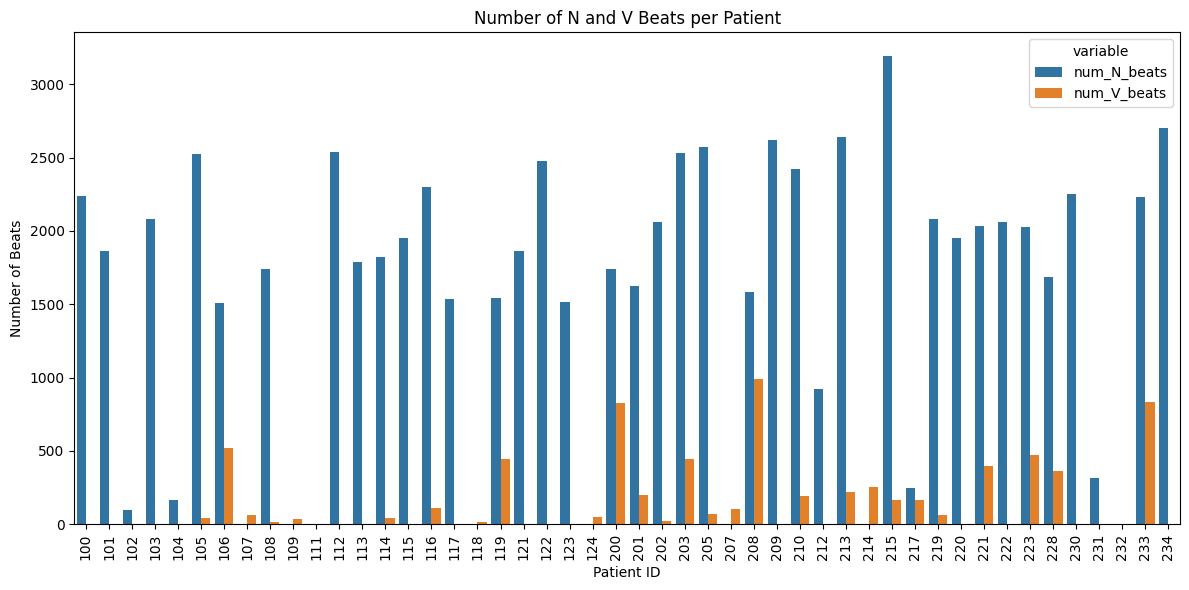

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
df_summary_sorted = df_summary.sort_values('patient_id')

sns.barplot(data=df_summary_sorted.melt(id_vars='patient_id', value_vars=['num_N_beats', 'num_V_beats']),
            x='patient_id', y='value', hue='variable')
plt.title('Number of N and V Beats per Patient')
plt.ylabel('Number of Beats')
plt.xlabel('Patient ID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### N to V Ratio

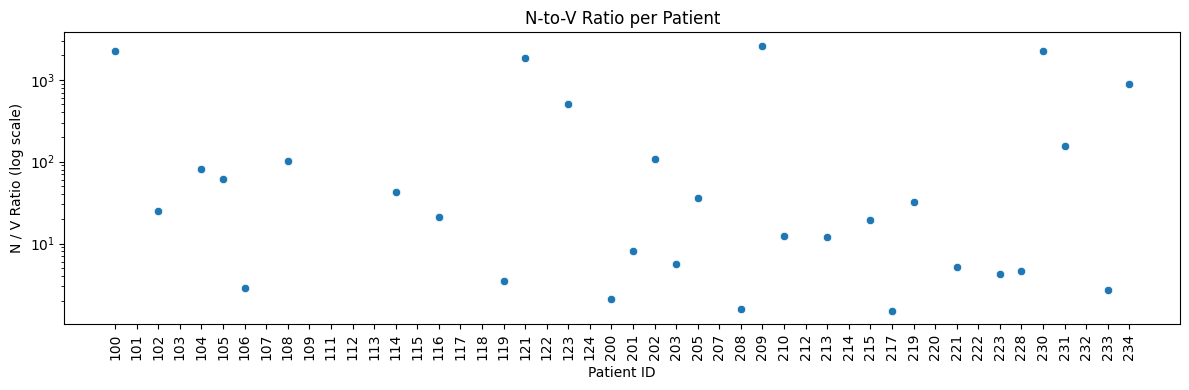

In [4]:
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df_summary_sorted, x='patient_id', y='N_to_V_ratio')
plt.title('N-to-V Ratio per Patient')
plt.yscale('log')
plt.ylabel('N / V Ratio (log scale)')
plt.xlabel('Patient ID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### Signal Duration

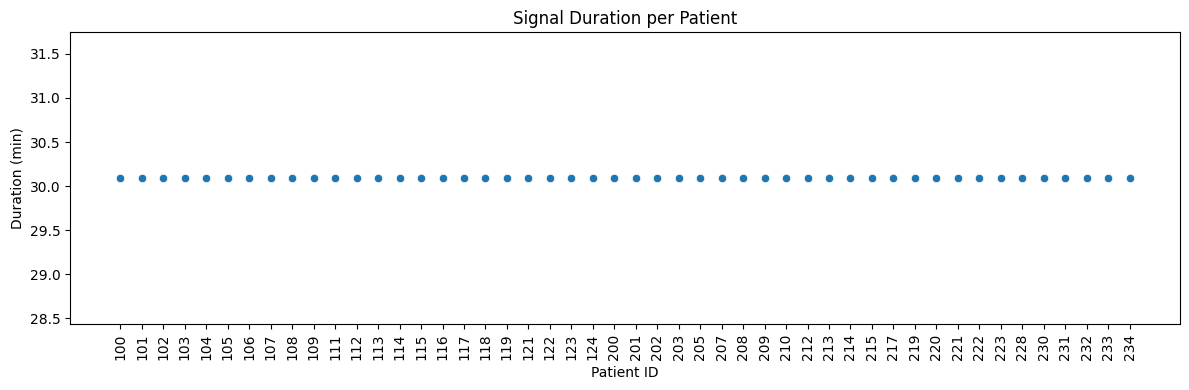

In [5]:
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df_summary_sorted, x='patient_id', y='signal_duration_min')
plt.title('Signal Duration per Patient')
plt.ylabel('Duration (min)')
plt.xlabel('Patient ID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### Average Heart Rate

/var/folders/c1/y8y5wht55pzct0drrqd44zvr0000gn/T/ipykernel_44706/3069529537.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_summary_sorted, x='patient_id', y='avg_heart_rate_bpm', palette='magma')


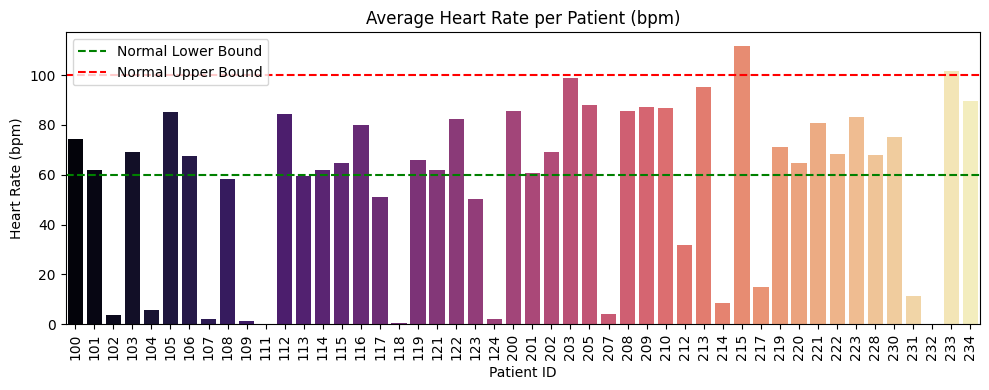

In [6]:
plt.figure(figsize=(10, 4))
sns.barplot(data=df_summary_sorted, x='patient_id', y='avg_heart_rate_bpm', palette='magma')
plt.title('Average Heart Rate per Patient (bpm)')
plt.ylabel('Heart Rate (bpm)')
plt.xlabel('Patient ID')
plt.xticks(rotation=90)
plt.axhline(60, color='green', linestyle='--', label='Normal Lower Bound')
plt.axhline(100, color='red', linestyle='--', label='Normal Upper Bound')
plt.legend()
plt.tight_layout()
plt.show()

##### Filter Out Unwanted Records

In [7]:
# Define thresholds
min_v_beats = 30           # Must have at least 30 V beats
max_n_to_v_ratio = 20      # To avoid heavy imbalance
hr_min, hr_max = 50, 110   # Exclude extreme heart rates

# Apply filtering
filtered_df = df_summary_sorted[
    (df_summary_sorted['num_V_beats'] >= min_v_beats) &
    (df_summary_sorted['N_to_V_ratio'] <= max_n_to_v_ratio) &
    (df_summary_sorted['avg_heart_rate_bpm'] >= hr_min) &
    (df_summary_sorted['avg_heart_rate_bpm'] <= hr_max)
]

# Optional: reset index
filtered_df = filtered_df.reset_index(drop=True)

# Show filtered patients
print(f"Selected {len(filtered_df)} patients:")
print(filtered_df[['patient_id', 'num_N_beats', 'num_V_beats', 'N_to_V_ratio', 'avg_heart_rate_bpm']])

Selected 12 patients:
   patient_id  num_N_beats  num_V_beats  N_to_V_ratio  avg_heart_rate_bpm
0         106         1507          520      2.898077                67.4
1         119         1543          444      3.475225                66.0
2         200         1743          826      2.110169                85.4
3         201         1625          198      8.207071                60.6
4         203         2529          444      5.695946                98.8
5         208         1586          992      1.598790                85.7
6         210         2423          194     12.489691                86.9
7         213         2641          220     12.004545                95.1
8         221         2031          396      5.128788                80.7
9         223         2029          473      4.289641                83.2
10        228         1688          362      4.662983                68.1
11        233         2230          831      2.683514               101.7


In [8]:
filtered_df.to_pickle("filtered_df.pkl")

In [9]:
filtered_df.columns.tolist()

['patient_id',
 'total_samples',
 'signal_duration_min',
 'sampling_rate',
 'num_beats_total',
 'num_N_beats',
 'num_V_beats',
 'N_to_V_ratio',
 'avg_RR_interval_sec',
 'avg_heart_rate_bpm',
 'signal',
 'ann_indices',
 'ann_symbols']